# Theoretical Foundations of Buffer Stock Saving

<cite data-cite="6202365/8AH9AXN2"></cite>

<p style="text-align: center;"><small><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></small></p>

[![econ-ark.org](https://img.shields.io/badge/Powered%20by-Econ--ARK-3e8acc.svg)](https://econ-ark.org/materials/BufferStockTheory)


<a id='interactive-dashboard'></a>

[This notebook](https://econ-ark.org/BufferStockTheory/#launch) uses the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit to reproduce and illustrate key results of the paper [Theoretical Foundations of Buffer Stock Saving](http://econ-ark.github.io/BufferStockTheory/BufferStockTheory).

An [interactive dashboard](https://econ-ark.org/BufferStockStockTheory/#Dashboard) allows you to modify parameters to see how the figures change.

- JupyterLab, click on the $\bullet$$\bullet$$\bullet$ patterns to expose the runnable code
- in either a Jupyter notebook or JupyterLab, click a double triangle to execute the code and generate the figures

`# Setup Python Below`

In [1]:
# This cell does some setup

# Import required python packages
import logging
import numpy as np
from copy import deepcopy
import warnings

# Ignore some harmless but alarming warning messages
warnings.filterwarnings("ignore")

# Plotting tools
import matplotlib.pyplot as plt

# Make required tools are installed
import os.path
import sys
import subprocess
if os.path.isdir('binder'):  # Folder defining requirements exists
    # File requirements.out should be created first time notebook is run
    if not os.path.isfile('./binder/requirements.out'):
        try:
            output = subprocess.check_output(
                [sys.executable, '-m', 'pip', 'install','--user','-r','./binder/requirements.txt'],stderr=subprocess.STDOUT) 
            requirements_out = open("./binder/requirements.out","w")
            requirements_out.write(output.decode("utf8"))
        except subprocess.CalledProcessError as e:
            print(output.decode("utf8"))
            print(e.output.decode("utf8"),e.returncode)

`# Setup HARK Below`

In [2]:
# Import required HARK tools
from HARK import __version__ as HARKversion
from HARK.utilities import (
    plot_funcs, find_gui, make_figs, determine_platform,
    test_latex_installation, setup_latex_env_notebook)
from HARK.ConsumptionSaving.ConsIndShockModel import (
    PerfForesightConsumerType, IndShockConsumerType, init_perfect_foresight, init_idiosyncratic_shocks)

# Code to allow a master "Generator" and derived "Generated" versions
# Generator marking  - allows "$nb-Problems-And-Solutions → $nb-Problems → $nb" 
Generator = True  # Is this notebook the master or is it generated?

# Whether to save the figures to Figures_dir
saveFigs = True

# Whether to draw the figures
drawFigs = True

pf = determine_platform() # latex checking depends on platform
try: # test whether latex is installed on command line 
    latexExists = test_latex_installation(pf)
except ImportError:  # windows and MacOS requires manual latex install
    latexExists = False

setup_latex_env_notebook(pf, latexExists)

# check if GUI is present; if not then switch drawFigs to False and force saveFigs to be True
if not find_gui():
    drawFigs, saveFigs = False, True

# Font sizes for figures
fssml, fsmid, fsbig = 18, 22, 26

def makeFig(figure_name, target_dir="../../Figures"):
    print('')
    make_figs(figure_name, saveFigs, drawFigs, target_dir)
    print('')
    
base_params = deepcopy(init_idiosyncratic_shocks)
# Uninteresting housekeeping and details
# Make global variables for the things that were lists above 
PermGroFac, permShkStd, tranShkStd = base_params['PermGroFac'][0], base_params['permShkStd'][0], base_params['tranShkStd'][0]

# Some technical settings that are not interesting for our purposes
base_params['LivPrb'] = [1.0]   # 100 percent chance of living to next period
base_params['BoroCnstArt'] = None    # No artificial borrowing constraint

## [The Problem](http://econ-ark.github.io/BufferStockTheory/BufferStockTheory/#The-Problem)

The paper defines and calibrates a small set of parameters:

\begin{align}
 &
\renewcommand{\APF}{\pmb{\unicode[0.55,0.05]{0x00DE}}}
\newcommand{\PatFac}{\pmb{\unicode[0.55,0.05]{0x00DE}}}
\newcommand{\PatRte}{\pmb{\unicode[0.55,0.05]{0x00FE}}}
\newcommand{\aLev}{\mathbf{a}}
\newcommand{\CRRA}{\rho}
\newcommand{\cLev}{{\mathbf{c}}}
\newcommand{\aNrm}{{a}}
\newcommand{\bNrm}{{b}}
\newcommand{\cNrm}{{c}}
\newcommand{\dNrm}{{d}}
\newcommand{\hNrm}{{h}}
\newcommand{\mNrm}{{m}}
\newcommand{\vNrm}{{v}}
\newcommand{\aLev}{{\mathbf{a}}}
\newcommand{\bLev}{{\mathbf{b}}}
\newcommand{\cLev}{{\mathbf{c}}}
\newcommand{\dLev}{{\mathbf{d}}}
\newcommand{\hLev}{{\mathbf{h}}}
\newcommand{\mLev}{{\mathbf{m}}}
\newcommand{\pLev}{{\mathbf{p}}}
\newcommand{\vLev}{{\mathbf{v}}}
\newcommand{\cFunc}{\mathrm{c}}
\newcommand{\uFunc}{\mathrm{u}}
\newcommand{\RNrm}{\mathcal{R}}
\newcommand{\DiscFac}{\beta}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\IncUnemp}{\mu}
\newcommand{\MPC}{\kappa}
\newcommand{\PermGroFac}{\Gamma}
\newcommand{\PermGroFacAdj}{\tilde{\Gamma}}
\newcommand{\PermShkStd}{\sigma_\Psi}
\newcommand{\permShkStd}{\sigma_\psi}
\newcommand{\PermShk}{\Psi} % New
\newcommand{\permShk}{\psi} % New
\newcommand{\Rfree}{\mathsf{R}}
\newcommand{\Trg}{\hat}
\newcommand{\StE}{\check}
\newcommand{\Thorn}{\pmb{\TH}}
\newcommand{\TranShkStd}{\sigma_\Theta}
\newcommand{\TranShk}{\Theta}
\newcommand{\tranShk}{\theta}
\newcommand{\tranShkStd}{\sigma_{\theta}}
\newcommand{\UnempPrb}{\wp}
\newcommand\maththorn{\mathord{\pmb{\text{\TH}}}}
\end{align}

| Parameter | Description | Python Variable | Value |
|:---:      | :---:       | :---:  | :---: |
| $\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\tranShk^{\large u}$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\permShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

that define the preferences and environment of microeconomic consumers as detailed below.

The objective of such a consumer with a horizon of $n$ periods is to maximize the value obtained from the stream of consumption __**c**__ from period $t=T-n$ to a terminal period $T$:

\begin{equation}
\mathbf{v}_{t} = \sum_{i=0}^{n} \DiscFac^{n}\mathrm{u}(\mathbf{c}_{t+n})
\end{equation}

The infinite-horizon solution is the limit of the first period solution $\mathrm{c}_{T-n}$ as the horizon $n$ goes to infinity.

### Details
For a microeconomic consumer who begins period $t$ with __**m**__arket resources boldface $\mLev_{t}$ (=net worth plus current income), the amount that remains after __**c**__onsumption of $\cLev_{t}$ will be end-of-period __**a**__ssets $\aLev_{t}$,

<!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $\aLev_{t}$ augmented by return factor $R$:-->

\begin{eqnarray}
\aLev_{t}   &=&\mLev_{t}-\cLev_{t}. \notag
\end{eqnarray}

The consumer's __**p**__ermanent noncapital income $\pLev$ grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable multiplicative shock $\Ex_{t}[\permShk_{t+1}]=1$,

\begin{eqnarray}
\pLev_{t+1} & = & \pLev_{t} \PermGroFac \permShk_{t+1}, \notag
\end{eqnarray}

and, if the consumer is employed, actual income is permanent income multiplied by a transitory shock $\tranShk^{\large e}$.  There is also a probability $\UnempPrb$ that the consumer will be temporarily unemployed and experience income of $\tranShk^{\large u}  = 0$.  We construct $\tranShk^{\large e}$ so that its mean value is $1/(1-\UnempPrb)$ because in that case the mean level of the transitory shock (accounting for both unemployed and employed states) is exactly

\begin{eqnarray}
\Ex_{t}[\tranShk_{t+1}] & = & \tranShk^{\large{u}}  \times \UnempPrb + (1-\UnempPrb) \times \Ex_{t}[\tranShk^{\large{e}}_{t+1}] \notag
\\ & = & 0 \times \UnempPrb + (1-\UnempPrb) \times 1/(1-\UnempPrb)  \notag
\\ & = & 1. \notag
\end{eqnarray}

  We can combine the unemployment shock $\tranShk^{\large u}$ and the transitory shock to employment income $\tranShk^{\large e}$ into $\tranShk _{t+1}$, so that next period's market resources are
\begin{eqnarray}
    \mLev_{t+1} &=& \aLev_{t}\Rfree +\pLev_{t+1}\tranShk_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(\cLev)=\frac{\cLev^{1-\CRRA}}{1-\CRRA}$, the paper shows that the problem can be written in terms of ratios (nonbold font) of level (bold font) variables to permanent income, e.g. $m_{t} \equiv \mLev_{t}/\pLev_{t}$, and the Bellman form of [the problem reduces to](https://econ-ark.github.io/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \DiscFac~\Ex_{t} [(\PermGroFac\permShk_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& a_t \Rfree/(\PermGroFac \permShk_{t+1}) + \tranShk_{t+1} \\
\end{eqnarray*}

In [3]:
# Set the parameters for the baseline results in the paper
base_params['PermGroFac'] = [1.03]  # Permanent income growth factor
base_params['Rfree'] = Rfree = 1.04  # Interest factor on assets
base_params['DiscFac'] = DiscFac = 0.96  # Time Preference Factor
base_params['CRRA'] = CRRA = 2.00  # Coefficient of relative risk aversion
# Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['UnempPrb'] = UnempPrb = 0.005
base_params['IncUnemp'] = IncUnemp = 0.0   # Induces natural borrowing constraint
base_params['permShkStd'] = [0.1]   # Standard deviation of log permanent income shocks
base_params['tranShkStd'] = [0.1]   # Standard deviation of log transitory income shocks

## Convergence of the Consumption Rules

Under the given parameter values, [the paper's first figure](https://econ-ark.github.io/BufferStockTheory/#Convergence-of-the-Consumption-Rules) depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and earlier periods $(c_{T-n})$.  The consumption function to which these converge is $c(m)$:

\begin{equation}
c(m) = \lim_{n \uparrow \infty} c_{T-n}(m) \notag
\end{equation}

`# Create a buffer stock consumer instance:`

In [4]:
# Create a buffer stock consumer instance by invoking the IndShockConsumerType class
# with the parameter dictionary "base_params"

base_params['cycles'] = 100  # periods to solve from end
# Construct finite horizon agent with baseline parameters
baseAgent_Fin = \
    IndShockConsumerType(**base_params,
                         quietly=True)  # Don't say anything during setup

baseAgent_Fin.solve(quietly=True)  # Solve the model quietly

baseAgent_Fin.unpack('cFunc')  # Retrieve consumption functions
cFunc = baseAgent_Fin.cFunc    # Shorthand

`# Plot the consumption rules:`


Saving figure cFuncsConverge in ../../Figures


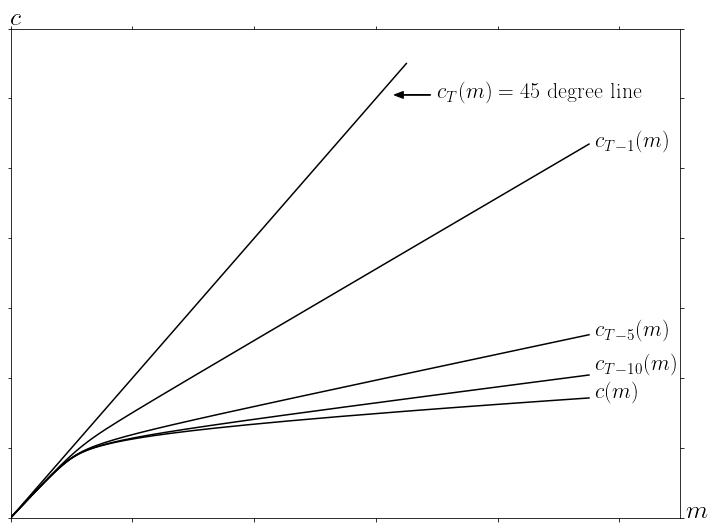

In [5]:
# Plot the different consumption rules for the different periods

mPlotMin = 0
mLocCLabels = 9.6  # Defines horizontal limit of figure
mPlotTop = 6.5    # Defines maximum m value where functions are plotted
mPts = 1000      # Number of points at which functions are evaluated

mBelwLabels = np.linspace(mPlotMin, mLocCLabels-0.1, mPts)  # Range of m below loc of labels
m_FullRange = np.linspace(mPlotMin, mPlotTop, mPts)        # Full plot range
# c_Tm0  defines the last period consumption rule (c=m)

T = -1  # Solution in the last period
c_Tm0 = m_FullRange
# c_Tm1 defines the second-to-last period consumption rule
c_Tm1 = cFunc[T-1](mBelwLabels)
c_Tm5 = cFunc[T-5](mBelwLabels)  # c_Tm5 defines the T-5 period consumption rule
c_Tm10 = cFunc[T-10](mBelwLabels)  # c_Tm10 defines the T-10 period consumption rule
# c_Limt defines limiting inﬁnite-horizon consumption rule
c_Limt = baseAgent_Fin.cFunc[0](mBelwLabels)

plt.figure(figsize=(12, 9))
plt.rcParams['font.size'], plt.rcParams['font.weight'] = fsmid, 'bold'

xMin, xMax = 0, 11
yMin, yMax = 0, 7
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)

plt.plot(mBelwLabels, c_Limt, color='black')
plt.plot(mBelwLabels, c_Tm1, color='black')
plt.plot(mBelwLabels, c_Tm5, color='black')
plt.plot(mBelwLabels, c_Tm10, color='black')
plt.plot(m_FullRange, c_Tm0, color='black')
plt.text(yMax, yMax-1    , r'$c_{T   }(m) = 45$ degree line')
#plt.text(yMax, yMax-1    , r'$c_{T   }(m) = 45 \mathfrak{Fraktur}\;\mathbf{\mathfrak{Fraktur}}$')
plt.text(mLocCLabels, 5.3, r'$c_{T-1 }(m)$')
plt.text(mLocCLabels, 2.6, r'$c_{T-5 }(m)$')
plt.text(mLocCLabels, 2.1, r'$c_{T-10}(m)$')
plt.text(mLocCLabels, 1.7, r'$c(m)       $')
plt.arrow(6.9, 6.05, -0.6, 0, head_width=0.1, width=0.001,
          facecolor='black', length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False, left='off',
                right='off', bottom='off', top='off')
plt.text(0, 7.05, "$c$", fontsize=fsbig)
plt.text(xMax+0.1, 0, "$m$", fontsize=fsbig)

# Save the figure

makeFig('cFuncsConverge')  # Comment out if you want to run uninterrupted

Use the [interactive dashboard](#interactive-dashboard) to explore the effects of changes in patience, risk aversion, or risk

### PROBLEM: Natural Borrowing Constraint Approaches Artificial Constraint

Show numerically the result that is proven analytically in [The-Liquidity-Constrained-Solution-as-a-Limit](https://econ-ark.github.io/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit), by solving the model for successively smaller values of $\UnempPrb$.
   * You need only to solve for the second-to-last period of life to do this
      * `TwoPeriodModel = IndShockConsumerType(**base_params)`
      * `TwoPeriodModel.cycles = 2   # Make this type have a two period horizon (Set T = 2)`

   * You should show the consumption rules for different values of $\UnempPrb$ on the same graph
      * To make this easier, you will want to use the plot_funcs command:
         * `from HARK.utilities import plot_funcs_der, plot_funcs`

Create a cell or cells in the notebook below this cell and put your solution there; comment on the size of $\UnempPrb$ needed to make the two models visually indistinguishable

## Factors and Conditions

### [The Finite Human Wealth Condition](http://econ-ark.github.io/BufferStockTheory/#Human-Wealth)

Human wealth for a perfect foresight consumer is the present discounted value of future income:

\begin{eqnarray}\notag
\hLev_{t} & = & \Ex_{t}[\pLev_{t} + \Rfree^{-1} \pLev_{t+1} + \Rfree^{2} \pLev_{t+2} ... ] \\ \notag
      & = & \pLev_{t} \left(1 + (\PermGroFac/\Rfree) + (\PermGroFac/\Rfree)^{2} ... \right)
\end{eqnarray}

which approaches infinity as the horizon extends if $\PermGroFac/\Rfree \geq 1$.  We say that the 'Finite Human Wealth Condition' [(FHWC)](https://econ-ark.github.io/BufferStockTheory/#FHWC) holds if
$0 \leq (\PermGroFac/\Rfree) < 1$.

### [Absolute Patience and the AIC](https://econ-ark.github.io/BufferStockTheory/#AIC)

The paper defines the Absolute Patience Factor [(APF)](https://econ-ark.github.io/BufferStockTheory/#APF) as being equal to the ratio $\cLev_{t+1}/\cLev_{t}$ for a perfect foresight consumer.  (The Old English character Thorn used for this object in the paper cannot reliably be rendered in Jupyter notebooks; it may appear as capital Phi):

\begin{equation}
\PatFac = (\Rfree \DiscFac)^{1/\CRRA}
\end{equation}

If $\APF = 1$, a perfect foresight consumer will spend at exactly the level of $\cLev$ that can be sustained perpetually (given their current and future resources).  If $\APF < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\APF > 1$ consumption will grow over time.



### [Growth Patience and the GICRaw](https://econ-ark.github.io/BufferStockTheory/#GIC)

For a [perfect foresight consumer](https://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA), whether the ratio $c$=__**c**__/__**p**__ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income; that ratio is measured by the [Perfect Foresight Growth Patience Factor](https://econ-ark.github.io/BufferStockTheory/#PFGPF):

\begin{eqnarray}
\APF_{\PermGroFac} & = & \APF/\PermGroFac
\end{eqnarray}
and whether the $c$ is falling or rising over time depends on whether $\APF_{\PermGroFac}$ is below or above 1.

An analogous condition can be defined when there is uncertainty about permanent income.  Defining $\tilde{\PermGroFac} = (\Ex[\permShk^{-1}])^{-1}\PermGroFac$, the
['Growth Impatience Condition'](https://econ-ark.github.io/BufferStockTheory/#GIC) determines whether, _in expectation_, the stochastic value of $c$ is rising, constant, or falling over time:

\begin{eqnarray}
  \APF/\tilde{\PermGroFac} & < & 1.
\end{eqnarray}

### [The Finite Value of Autarky Condition (FVAC)](https://econ-ark.github.io/BufferStockTheory/#Autarky-Value)

The paper [shows](https://econ-ark.github.io/BufferStockTheory/#Autarky-Value) that a consumer who planned to spend his permanent income $\{ \pLev_{t}, \pLev_{t+1}, ...\} $ in every period would have value defined by

\begin{equation*}
\vLev_{t}^{\text{autarky}} = \uFunc(\pLev_{t})\left(\frac{1}{1-\DiscFac \PermGroFac^{1-\CRRA} \Ex[\permShk^{1-\CRRA}]}\right)
\end{equation*}

and defines the ['Finite Value of Autarky Condition'](https://econ-ark.github.io/BufferStockTheory/#Autarky-Value) as the requirement that the denominator be a positive finite number:

\begin{equation*}
\DiscFac \PermGroFac^{1-\CRRA} \Ex[\permShk^{1-\CRRA}] < 1
\end{equation*}

### [The Weak Return Impatience Condition (WRIC)](https://econ-ark.github.io/BufferStockTheory/#WRIC)

The [Return Impatience Condition](https://econ-ark.github.io/BufferStockTheory/#RIC) $\APF/\Rfree < 1$ has long been understood to be required for the perfect foresight model to have a nondegenerate solution (a common special case is when $\CRRA=1$; in this case $\APF = \Rfree \DiscFac$ so $\APF<1$ reduces to the familiar condition $\DiscFac < \Rfree$).

If the RIC does not hold, the consumer is so patient that the optimal consumption function approaches zero as the horizon extends indefinitely.

When the probability of unemployment is $\UnempPrb$, the paper articulates an analogous (but weaker) condition:

\begin{eqnarray}
 \UnempPrb^{1/\CRRA} \APF/\Rfree & < & 1
\end{eqnarray}

# Key Results

## [Nondegenerate Solution Requires FVAC and WRIC](https://econ-ark.github.io/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution)

A main result of the paper is that the conditions required for the model to have a nondegenerate limiting solution ($0 < c(m) < \infty$ for feasible $m$) are that the Finite Value of Autarky (FVAC) and Weak Return Impatience Condition (WRIC) hold.

## [Natural Borrowing Constraint limits to Artificial Borrowing Constraint](https://econ-ark.github.io/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit)

Defining $\chi(\UnempPrb)$ as the consumption function associated with any particular probability of a zero-income shock $\UnempPrb$, and defining $\hat{\chi}$ as the consumption function that would apply in the absence of the transitory zero-income shocks but in the presence of an 'artificial' borrowing constraint requiring $a \geq 0$ (_a la_ Deaton (1991)), the paper shows that

\begin{eqnarray}
\lim_{\UnempPrb \downarrow 0}~\chi(\UnempPrb) & = & \hat{\chi}
\end{eqnarray}

That is, as $\UnempPrb$ approaches zero the problem with uncertainty becomes identical to the problem that instead has constraints.  (See [Precautionary Saving and Liquidity Constraints](https://econ-ark.github.io/LiqConstr) for a full treatment of the relationship between precautionary saving and liquidity constraints).

## [$\cFunc(m)$ can be Finite Even When Human Wealth Is Infinite](https://econ-ark.github.io/BufferStockTheory/#When-The-GICRaw-Fails)

In the perfect foresight model, if $\Rfree < \PermGroFac$ the PDV of future labor income approaches infinity as the horizon extends and so the limiting consumption function is $c(m) = \infty$ for all $m$.  Many models have no well-defined limiting solution when human wealth is infinite.

The presence of uncertainty changes this: Even when limiting human wealth is infinite, the limiting consumption function is finite for all values of $m$.

This is because uncertainty imposes a "natural borrowing constraint" that deters the consumer from borrowing against their unbounded (but uncertain) future labor income.

A [table](https://econ-ark.github.io/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) puts this result in the context of implications of other conditions and restrictions.



## [Unique and Stable Values of $\mNrm$](https://econ-ark.github.io/BufferStockTheory/#Unique-Stable-Points)

Assuming that the **FVAC** and **WRIC** hold so that the problem has a nondegenerate solution, under more stringent conditions its dynamics can also be shown to exhibit certain kinds of stability.  Two particularly useful kinds of stability are existence of a 'target' value of market resources $\Trg{\mNrm}$ and a 'pseudo-steady-state' value $\StE{\mNrm}$.

### [If the GIC-Nrm Holds, $\exists$ a finite 'target' $\mNrm$](https://econ-ark.github.io/BufferStockTheory/#onetarget)

Section [Individual Target Wealth](https://econ-ark.github.io/BufferStockTheory/#onetarget) shows that, under parameter values for which the limiting consumption function exists, if the [GICNrm](https://econ-ark.github.io/BufferStockTheory/#GICNrm) holds then there will be a value $\Trg{m}$ such that:

\begin{eqnarray*}
\Ex[m_{t+1}] & > & m_{t}~\text{if $m_{t} < \Trg{m}$} \\
\Ex[m_{t+1}] & < & m_{t}~\text{if $m_{t} > \Trg{m}$} \\
\Ex[m_{t+1}] & = & m_{t}~\text{if $m_{t} = \Trg{m}$}
\end{eqnarray*}

[An equation](https://econ-ark.github.io/BufferStockTheory/#mTargImplicit) in the paper tells us that, for the expected normalized interest factor $\bar{\RNrm}=\mathbb{E}[\Rfree/(\PermGroFac \PermShk)]$, if $\mNrm_{t}=\Trg{m}$ then:

\begin{align}
(\Trg{\mNrm}-\cFunc(\Trg{\mNrm}))\bar{\RNrm}+1 & = \Trg{\mNrm}
%\\ \Trg{\mNrm}(1-\bar{\RNrm}^{-1})+\bar{\RNrm}^{-1} & = \Trg{\cNrm}
%\\ \Trg{\cNrm} & = \Trg{\mNrm} - (\Trg{\mNrm} - 1)\bar{\RNrm}^{-1}
\end{align}

which can be solved numerically for the unique $\Trg{\mNrm}$ that satisfies it.

### [If the GIC-Raw Holds, $\exists$ a finite 'pseudo-steady-state' $\mNrm$](https://econ-ark.github.io/BufferStockTheory/#Collective-Stability)

Section [Collective Stability and the Pseudo-Steady-State](https://econ-ark.github.io/BufferStockTheory/#Collective-Stability) shows that, under parameter values for which the limiting consumption function exists, if the **GIC** holds then there will be a value $\StE{m}$ such that:

\begin{eqnarray*}
\Ex_{t}[\mLev_{t+1}/\mLev_{t}] & > & \PermGroFac~\text{if $m_{t} < \StE{m}$} \\
\Ex_{t}[\mLev_{t+1}/\mLev_{t}] & < & \PermGroFac~\text{if $m_{t} > \StE{m}$} \\
\Ex_{t}[\mLev_{t+1}/\mLev_{t}] & = & \PermGroFac~\text{if $m_{t} = \StE{m}$}
\end{eqnarray*}

[An equation](https://econ-ark.github.io/BufferStockTheory/#balgrostableSolve) in the paper tells us that if $\mNrm_{t}=\StE{m}$ then:

\begin{align}
(\StE{\mNrm}-\cFunc(\StE{\mNrm}))\RNrm+1 & = \StE{\mNrm}
\end{align}

which can be solved numerically for the unique $\StE{\mNrm}$ that satisfies it.


### [Example With Finite Pseudo-Steady-State But Infinite Target Wealth](https://econ-ark.github.io/BufferStockTheory/#GICNrmFailsButGICRawHolds)

[A figure](https://econ-ark.github.io/BufferStockTheory/#GICNrmFailsButGICRawHolds) depicts a solution when the **FVAC** (Finite Value of Autarky Condition) and **WRIC** hold (so that the model has a solution), the **GIC** holds, so the model has a pseudo-steady-state $\StE{\mNrm}$, but the **GIC-Nrm** fails, so the model does not have an individual target wealth ratio $\Trg{\mNrm}$ (or, rather, the target wealth ratio is infinity, as can be seen by the fact that the level of $\cNrm$ is always below the level that would keep $\Ex_{t}[\Delta \mNrm_{t+1}] = 0$).

This example was constructed by quadrupling the variance of the permanent shocks from the baseline parameterization.  The extra precautionary saving induced by increased uncertainty is what pushes the agent into the region without a target wealth ratio.

`# Create an example consumer instance where the GICNrm fails but the GIC Holds:`

In [7]:
# GICNrmFailsButGICRawHolds Example

base_params['cycles'] = 0  # revert to default of infinite horizon
GICNrmFailsButGICRawHolds_params = dict(base_params)

# Increase patience by increasing risk
GICNrmFailsButGICRawHolds_params['permShkStd'] = [0.2]

# Create an agent with these parameters
GICNrmFailsButGICRawHolds = \
    IndShockConsumerType(**GICNrmFailsButGICRawHolds_params,
                         quietly=False,  # If True, output suppressed
                         )


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.96
	LivPrb: 1.0
	CRRA: 2.0
	Rfree: 1.04
	PermGroFac: 1.03
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe99045acd0>
	permShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe990e1b970>
	tranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe970d67370>
	BoroCnstArt: None
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * permShk)
	bNrm = kNrm * RNrm
	yNrm = tranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APF=0.99920 satisfies the Absolute Impatience Condition (AIC), APF < 1:
    ht

.

`# Solve that consumer's problem:`

In [8]:
# Solve the model for these parameter values
GICNrmFailsButGICRawHolds.tolerance = 0.01

GICNrmFailsButGICRawHolds.solve(quietly=True)  # Suppress output

# Because we are trying to solve a problem very close to the critical patience
# values, we want to do it with extra precision to be sure we've gotten the
# answer right.  We can retrieve the distance between the last two solutions:

distance_original = GICNrmFailsButGICRawHolds.solution[0].distance_last

# But high precision would have slowed things down if we used it from the start

# Instead, we can take the solution obtained above, and continue it but with
# parameters that will yield a more precise answer:

# Solve with quadruple the normal range
GICNrmFailsButGICRawHolds.aXtraMax = GICNrmFailsButGICRawHolds.aXtraMax * 10

# Solve over four times as many gridpoints
GICNrmFailsButGICRawHolds.aXtraCount = GICNrmFailsButGICRawHolds.aXtraCount * 4

GICNrmFailsButGICRawHolds.update_assets_grid()

# Solve to a 10 times tighter degree of error tolerance
GICNrmFailsButGICRawHolds.tolerance = GICNrmFailsButGICRawHolds.tolerance/10

# When the solver reaches its tolerance threshold, it changes the solver
# attribute stge_kind to have 'iter_status' of 'finished'
# If we want to continue the solution (having changed something, as above)
# To continue the solution from where we left off, we just change the
# 'iter_status' to 'iterator' and tell it to ".solve()" again

GICNrmFailsButGICRawHolds.solution[0].stge_kind['iter_status'] = 'iterator'
# continue solving

# Setting messaging_level to NOTSET prints all info including progress
GICNrmFailsButGICRawHolds.solve(messaging_level=logging.NOTSET, quietly=False)

# Test whether the new solution meets a tighter tolerance than before:
distance_now = GICNrmFailsButGICRawHolds.solution[0].distance_last
print('\ndistance_now < distance_original: ' +
      str(distance_now < distance_original))

# Again increase the range
GICNrmFailsButGICRawHolds.aXtraMax = GICNrmFailsButGICRawHolds.aXtraMax * 10

# and gridpoints
GICNrmFailsButGICRawHolds.aXtraCount = GICNrmFailsButGICRawHolds.aXtraCount * 2

GICNrmFailsButGICRawHolds.update_assets_grid()

# and decrease error tolerance
GICNrmFailsButGICRawHolds.tolerance = GICNrmFailsButGICRawHolds.tolerance/10


GICNrmFailsButGICRawHolds.solution[0].stge_kind['iter_status'] = 'iterator'
# continue solving
GICNrmFailsButGICRawHolds.solve(messaging_level=logging.DEBUG, quietly=False)

# Test whether the new solution meets a tighter tolerance than before:
distance_now = GICNrmFailsButGICRawHolds.solution[0].distance_last
print('\ndistance_now < distance_original: ' +
      str(distance_now < distance_original))


The Absolute Patience Factor, APF=0.99920 satisfies the Absolute Impatience Condition (AIC), APF < 1:
    https://econ-ark.github.io/BufferStockTheory/#AIC

    Because the APF < 1,  the absolute amount of consumption is expected to fall over time.  


The Finite Human Wealth Factor, FHWF=0.99038 satisfies the Finite Human Wealth Condition (FHWC), FHWF < 1:
    https://econ-ark.github.io/BufferStockTheory/#FHWC

    Therefore, the limiting consumption function is not c(m)=Infinity.
  Human wealth normalized by permanent income is 104.00000.


The Return Patience Factor, RPF=0.96077 satisfies the Return Impatience Condition (RIC), RPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#RPF

    Therefore, the limiting consumption function is not c(m)=0 for all m


The Growth Patience Factor, GPF=0.97010 satisfies the Growth Impatience Condition (GIC), GPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICRaw

    Therefore, for a perfect foresight consumer, the ratio of indi

Finished cycle # 000043 in  0.019987 seconds, solution distance = 1.440e+02
Finished cycle # 000044 in  0.033330 seconds, solution distance = 9.008e-02
Finished cycle # 000045 in  0.047881 seconds, solution distance = 8.525e-02
Finished cycle # 000046 in  0.062431 seconds, solution distance = 8.069e-02
Finished cycle # 000047 in  0.077663 seconds, solution distance = 7.639e-02
Finished cycle # 000048 in  0.090628 seconds, solution distance = 7.232e-02
Finished cycle # 000049 in  0.103901 seconds, solution distance = 6.848e-02
Finished cycle # 000050 in  0.117531 seconds, solution distance = 6.485e-02
Finished cycle # 000051 in  0.135654 seconds, solution distance = 6.143e-02
Finished cycle # 000052 in  0.151494 seconds, solution distance = 5.821e-02
Finished cycle # 000053 in  0.167015 seconds, solution distance = 5.517e-02
Finished cycle # 000054 in  0.182966 seconds, solution distance = 5.230e-02
Finished cycle # 000055 in  0.199903 seconds, solution distance = 4.959e-02
Finished cyc


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.96
	LivPrb: 1.0
	CRRA: 2.0
	Rfree: 1.04
	PermGroFac: 1.03
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe9b0a0e940>
	permShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe9b09e74c0>
	tranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe980b52910>
	BoroCnstArt: None
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * permShk)
	bNrm = kNrm * RNrm
	yNrm = tranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APF=0.99920 satisfies the Absolute Impatience Condition (AIC), APF < 1:
    ht

....
distance_now < distance_original: True


`# Plot the results:`


Saving figure GICNrmFailsButGICRawHolds in ../../Figures


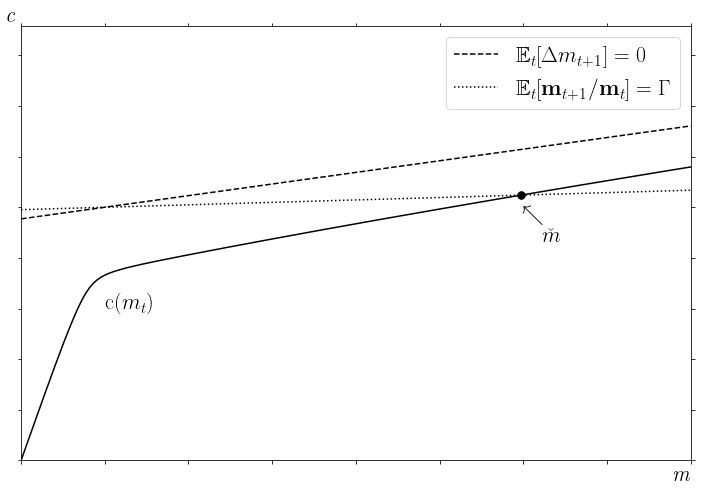


Finite mNrmStE but infinite mNrmTrg


In [9]:
# Plot GICNrmFailsButGICRawHolds

soln = GICNrmFailsButGICRawHolds.solution[0]  # Short alias for solution

Bilt, Pars, E_tp1_ = soln.Bilt, soln.Pars, soln.E_Next_
cFunc = Bilt.cFunc

fig, ax = plt.subplots(figsize=(12, 8))

[xMin, xMax] = [0.0, 8.0]
yMin = 0.0
yMax = E_tp1_.c_where_E_Next_m_tp1_minus_m_t_eq_0(xMax)*1.3

mPltVals = np.linspace(xMin, xMax, mPts)

if latexExists:
    c_Stable_Ind_txt = "$\Ex_{t}[\Delta m_{t+1}] = 0$"
    c_Stable_Agg_txt = "$\Ex_{t}[{\mathbf{m}}_{t+1}/{\mathbf{m}}_{t}] = \PermGroFac$"
else:
    c_Stable_Ind_txt = "$\mathsf{E}_{t}[\Delta m_{t+1}] = 0$"
    c_Stable_Agg_txt = "$\mathsf{E}_{t}[\mathbf{m}_{t+1}/\mathbf{m}_{t}] = \Gamma$"

cVals_Lmting_color = "black"
c_Stable_Agg_color = "black"  # "blue"
c_Stable_Ind_color = "black"  # "red"

cVals_Lmting = cFunc(mPltVals)
c_Stable_Ind = E_tp1_.c_where_E_Next_m_tp1_minus_m_t_eq_0(mPltVals)
c_Stable_Agg = E_tp1_.c_where_E_Next_permGroShk_times_m_tp1_minus_m_t_eq_0(
    mPltVals)

cVals_Lmting_lbl, = ax.plot(mPltVals, cVals_Lmting, color=cVals_Lmting_color)
c_Stable_Ind_lbl, = ax.plot(mPltVals, c_Stable_Ind,
                            color=c_Stable_Ind_color, linestyle="dashed", label=c_Stable_Ind_txt)
c_Stable_Agg_lbl, = ax.plot(mPltVals, c_Stable_Agg,
                            color=c_Stable_Agg_color, linestyle="dotted", label=c_Stable_Agg_txt)

ax.set_xlim(xMin, xMax)
ax.set_ylim(yMin, yMax)
ax.set_xlabel("$\mathit{m}$", fontweight='bold', fontsize=fsmid, loc="right")
ax.set_ylabel("$\mathit{c}$", fontweight='bold', fontsize=fsmid, loc="top", rotation=0)

ax.tick_params(labelbottom=False, labelleft=False, left='off',
               right='off', bottom='off', top='off')

ax.legend(handles=[c_Stable_Ind_lbl, c_Stable_Agg_lbl])
ax.legend(prop=dict(size=fsmid))

mNrmStE = Bilt.mNrmStE
cNrmStE = c_Stable_Agg = cFunc(mNrmStE)

ax.plot(mNrmStE, cNrmStE, marker=".", markersize=15, color="black")  # Dot at StE point
ax.text(1, 0.6, "$\mathrm{c}(m_{t})$", fontsize=fsmid)  # label cFunc

if latexExists:
    ax.text(mNrmStE+0.02, cNrmStE-0.10, r"$\nwarrow$", fontsize=fsmid)
    ax.text(mNrmStE+0.25, cNrmStE-0.18, r"$\StE{m}~$", fontsize=fsmid)
else:
    ax.text(mNrmStE+0.02, cNrmStE-0.10, r"$\nwarrow$", fontsize=fsmid)
    ax.text(mNrmStE+0.25, cNrmStE-0.18, r"$\check{m}~$", fontsize=fsmid)

makeFig('GICNrmFailsButGICRawHolds')
print('Finite mNrmStE but infinite mNrmTrg')

In the [interactive dashboard](#interactive-dashboard), see what happens as changes in the time preference rate (or changes in risk $\permShkStd$) change the consumer from _normalized-growth-patient_ $(\APF > \tilde{\PermGroFac})$ to _normalized-growth-impatient_ ($\APF < \tilde{\PermGroFac}$)

As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{baseAgent}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type) instead of only 100 periods

`# Construct infinite horizon solution for consumer with baseline parameters:`

In [10]:
# Find the infinite horizon solution

base_params['aXtraCount'] = base_params['aXtraCount'] * 20
base_params['CubicBool'] = False
base_params['cycles'] = 0  # Default for infinite horizon model

baseAgent_Inf = IndShockConsumerType(
    **base_params,
    horizon='infinite',  # Infinite horizon
    quietly=True)  # construct it silently


The Absolute Patience Factor, APF=0.99920 satisfies the Absolute Impatience Condition (AIC), APF < 1:
    https://econ-ark.github.io/BufferStockTheory/#AIC

The Finite Human Wealth Factor, FHWF=0.99038 satisfies the Finite Human Wealth Condition (FHWC), FHWF < 1:
    https://econ-ark.github.io/BufferStockTheory/#FHWC

The Return Patience Factor, RPF=0.96077 satisfies the Return Impatience Condition (RIC), RPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#RPF

The Growth Patience Factor, GPF=0.97010 satisfies the Growth Impatience Condition (GIC), GPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICRaw

The Normalized Growth Patience Factor GPFNrm, GPFNrm=0.97920 satisfies the Normalized Growth Impatience Condition (GICNrm), GPFNrm < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICNrm

The Mortality Adjusted Aggregate Growth Patience Factor, GPFLiv=0.97010 satisfies the Mortality Adjusted Aggregate Growth Impatience Condition (GICLiv):
    https://econ-ark.gi

### [Expected Consumption Growth, and Permanent Income Growth](https://econ-ark.github.io/BufferStockTheory/#AnalysisoftheConvergedConsumptionFunction)

The next figure, [Analysis of the Converged Consumption Function](https://econ-ark.github.io/BufferStockTheory/#cGroTargetFig), shows expected growth factors for the levels of consumption $\cLev$ and market resources $\mLev$ as a function of the market resources ratio $\mNrm$ for a consumer behaving according to the converged consumption rule, along with the growth factor for $\mNrm$ itself, and the (constant) growth factors for consumption and expected permanent income, $\APF$ and $\PermGroFac$.

The growth factor for consumption can be computed without knowing the _level_ of the consumer's permanent income:

\begin{eqnarray*}
\Ex_{t}[\cLev_{t+1}/\cLev_{t}] & = & \Ex_{t}\left[\frac{\pLev_{t+1}\cFunc(m_{t+1})}{\pLev_{t}\cFunc(m_{t})}\right] \\
% & = & \Ex_{t}\left[\frac{\PermGroFac \permShk_{t+1} \pLev_{t}}{\pLev_{t}}\frac{\cFunc(m_{t+1})}{\cFunc(m_{t})}\right] \\
& = & \left[\frac{\PermGroFac \permShk_{t+1} \cFunc(m_{t+1})}{\cFunc(m_{t})}\right]
\end{eqnarray*}

and similarly the growth factor for market resources is:

\begin{eqnarray*}
\Ex_{t}[\mLev_{t+1}/\mLev_{t}]
& = & \Ex_{t}\left[\frac{\PermGroFac \permShk_{t+1} \mNrm_{t+1}} {\mNrm_{t}} \right]
\\ & = & \Ex_{t}\left[\frac{\PermGroFac \permShk_{t+1} (\aNrm_{t}\Rfree/(\PermGroFac \permShk_{t+1}))+\PermGroFac \permShk_{t+1}\tranShk_{t+1}}
{\mNrm_{t}}\right]
%\\ & = & \Ex_{t}\left[\frac{\aNrm_{t}\Rfree+\tranShk_{t+1}}{\mNrm_{t}}\right]
\\ & = & \left[\frac{\aNrm_{t}\Rfree+\PermGroFac}{\mNrm_{t}}\right]
\end{eqnarray*}



For $\mNrm$ things are slightly more complicated:
\begin{eqnarray*}
\Ex_{t}[m_{t+1}]
& = & \Ex_{t}\left[(m_{t}-c_{t})(\Rfree/(\permShk_{t+1}\PermGroFac)) +\tranShk_{t+1}\right]\\
& = & a_{t}\Rfree\Ex_{t}\left[(\permShk_{t+1}\PermGroFac)^{-1}\right] +1 \\
\Ex_{t}\left[\frac{m_{t+1}}{m_{t}}\right] & = & \left(\frac{a_{t}\Rfree\Ex_{t}\left[(\permShk_{t+1}\PermGroFac)^{-1}\right]+1}{\mNrm_{t}}\right)
\end{eqnarray*}


`# Solve problem of consumer with baseline parameters:`

In [11]:
# Solve baseline parameters agent
tweaked_params = deepcopy(base_params)
tweaked_params['DiscFac'] = 0.970  # Tweak to make figure clearer
baseAgent_Inf = IndShockConsumerType(
    **tweaked_params, quietly=True)  # construct it silently

baseAgent_Inf.solve(
    quietly=False, messaging_level=logging.INFO)  # Solve it with info


The Absolute Patience Factor, APF=1.00439 violates the Absolute Impatience Condition (AIC), APF < 1:
    https://econ-ark.github.io/BufferStockTheory/#AIC

The Finite Human Wealth Factor, FHWF=0.99038 satisfies the Finite Human Wealth Condition (FHWC), FHWF < 1:
    https://econ-ark.github.io/BufferStockTheory/#FHWC

The Return Patience Factor, RPF=0.96576 satisfies the Return Impatience Condition (RIC), RPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#RPF

The Growth Patience Factor, GPF=0.97514 satisfies the Growth Impatience Condition (GIC), GPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICRaw

The Normalized Growth Patience Factor GPFNrm, GPFNrm=0.98429 satisfies the Normalized Growth Impatience Condition (GICNrm), GPFNrm < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICNrm

The Mortality Adjusted Aggregate Growth Patience Factor, GPFLiv=0.97514 satisfies the Mortality Adjusted Aggregate Growth Impatience Condition (GICLiv):
    https://econ-ark.git

.............................................................................................................


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.97
	LivPrb: 1.0
	CRRA: 2.0
	Rfree: 1.04
	PermGroFac: 1.03
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe9c0588460>
	permShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe9922a7a60>
	tranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7fe97129d550>
	BoroCnstArt: None
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * permShk)
	bNrm = kNrm * RNrm
	yNrm = tranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APF=1.00439 violates the Absolute Impatience Condition (AIC), APF < 1:
    htt

.

`# Plot growth factors for various model elements at steady state:`


Saving figure cGroTargetFig in ../../Figures


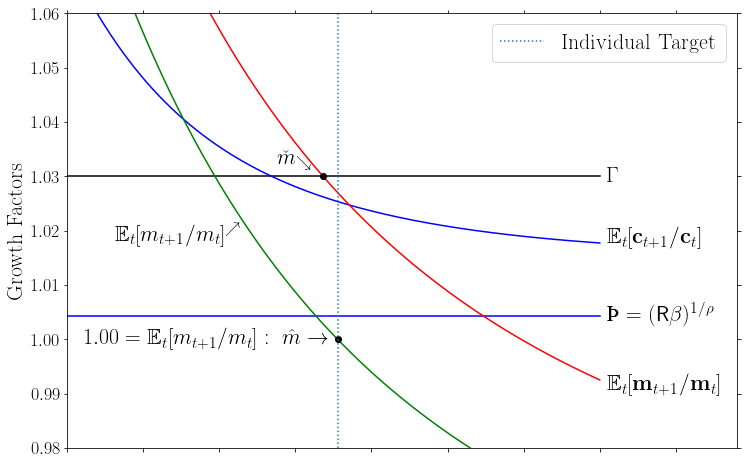

In [12]:
# Plot growth rates

soln = baseAgent_Inf.solution[0]
Bilt, Pars, E_Next_ = soln.Bilt, soln.Pars, soln.E_Next_

# Retrieve parameters (makes code more readable)
Rfree, DiscFac, CRRA, G = Pars.Rfree, Pars.DiscFac, Pars.CRRA, Pars.PermGroFac

color_cons, color_mrktLev, color_mrktNrm, color_perm = "blue", "red", "green", "black"

mPlotMin, mCalcMax, mPlotMax = 0.0, 50, 1.8

# Get steady state equilibrium and target values for m
mNrmStE, mNrmTrg = Bilt.mNrmStE, Bilt.mNrmTrg

pts_num = 200  # Plot this many points

m_pts = np.linspace(1, mPlotMax, pts_num)   # values of m for plot
c_pts = soln.cFunc(m_pts)                   # values of c for plot
a_pts = m_pts - c_pts                       # values of a

# Get ingredients for calculating growth factors, then calculate them
Ex_cLev_tp1_Over_pLev_t = [ 
    soln.E_Next_.cLev_tp1_Over_pLev_t_from_a_t(a) for a in a_pts]
Ex_mLev_tp1_Over_pLev_t = [
    soln.E_Next_.mLev_tp1_Over_pLev_t_from_a_t(a) for a in a_pts]
Ex_m_tp1_from_a_t = [
    soln.E_Next_.m_tp1_from_a_t(a) for a in a_pts]

Ex_cLevGro = np.array(Ex_cLev_tp1_Over_pLev_t)/c_pts
Ex_mLevGro = np.array(Ex_mLev_tp1_Over_pLev_t)/m_pts
Ex_mNrmGro = np.array(Ex_m_tp1_from_a_t)/m_pts

# Absolute Patience Factor = lower bound of consumption growth factor
APF = (Rfree*DiscFac)**(1.0/CRRA)

# Init figure and axes
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['font.size'], plt.rcParams['font.weight'] = fsmid, 'bold'

# Plot the Absolute Patience Factor line
ax.plot([0, mPlotMax], [APF, APF], color=color_cons)

# Plot the Permanent Income Growth Factor line
ax.plot([0, mPlotMax], [G, G]    , color=color_perm)

# Plot the expected consumption growth factor
ax.plot(m_pts, Ex_cLevGro        , color=color_cons)

# Plot expected growth for the level of market resources
ax.plot(m_pts, Ex_mLevGro        , color=color_mrktLev)

# Plot expected growth for the market resources ratio
ax.plot(m_pts, Ex_mNrmGro        , color=color_mrktNrm)

# Axes limits
GroFacMin, GroFacMax, xMin = 0.98, 1.06, 1.1
ax.set_xlim(xMin, mPlotMax * 1.1)
ax.set_ylim(GroFacMin, GroFacMax)

Thorn = u"\u00DE"

# If latex installed on system, plotting can look better
if latexExists:
    mNrmTrg_lbl = r'$1.00 = \Ex_{t}[\mNrm_{t+1}/\mNrm_{t}]:~ \Trg{m} \rightarrow~~$'
    PermGro_lbl = r"$\PermGroFac$"
    cLevGro_lbl = r"$\Ex_{t}[\cLev_{t+1}/\cLev_{t}]$"
    mNrmGro_lbl = r"$\Ex_{t}[\mNrm_{t+1}/\mNrm_{t}] ^{\nearrow}$"
    mLevGro_lbl = r"$\Ex_{t}[\mLev_{t+1}/\mLev_{t}]$"
    mNrmStE_lbl = r"$\check{\mNrm}_{\searrow}~$"    
    cLevAPF_lbl = r'$\pmb{\text{\TH}} = (\Rfree\DiscFac)^{1/\CRRA}$'
else:
    mNrmTrg_lbl = r'$\mathsf{E}_{t}[m_{t+1}/m_{t}]:~ \hat{m} \rightarrow~~$'
    PermGro_lbl = r"$\Gamma$"
    cLevGro_lbl = r"$\mathsf{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$"
    mNrmGro_lbl = r"$\mathsf{E}_{t}[m_{t+1}/m_{t}]^{\nearrow}$"
    mLevGro_lbl = r"$\mathsf{E}_{t}[\mathbf{m}_{t+1}/\mathbf{m}_{t}]$"
    mNrmStE_lbl = r"$m\check_{\searrow}$"    
    cLevAPF_lbl = Thorn + r'$= (\mathsf{R}\beta)^{1/\rho}$'


if mNrmTrg:  # Do not try to plot it if it does not exist!
    ax.text(mNrmTrg-0.01, 1.0-0.001, 
            mNrmTrg_lbl, ha='right')

ax.plot(mNrmStE, G  , marker=".", markersize=12, color="black")  # Dot at mNrmStE 
ax.plot(mNrmTrg, 1.0, marker=".", markersize=12, color="black")  # Dot at mNrmTrg 

mLevGro_lbl_xVal = mPlotMax
mLevGro_lbl_yVal = soln.E_Next_.mLev_tp1_Over_mLev_t(mLevGro_lbl_xVal)

mTrgGro_lbl_xVal = 0.92*mNrmTrg
mTrgGro_lbl_yVal = soln.E_Next_.m_tp1_Over_m_t(mTrgGro_lbl_xVal)

ax.text(mPlotMax+0.01, G-0.001,PermGro_lbl)
ax.text(mPlotMax+0.01, Ex_cLevGro[-1]  ,cLevGro_lbl)
ax.text(mPlotMax+0.01, APF-0.001       ,cLevAPF_lbl)
ax.text(mNrmStE-0.06, G+0.001,mNrmStE_lbl              ,va='bottom',ha='left')
ax.text(mTrgGro_lbl_xVal-0.01, mTrgGro_lbl_yVal-0.003,mNrmGro_lbl,va='bottom',ha='right')
ax.text(mLevGro_lbl_xVal+0.01, mLevGro_lbl_yVal+0.001,mLevGro_lbl,va='top')

# Ticks
ax.tick_params(labelbottom=False, labelleft=True, left='off', right='on', bottom='on', top='off')
plt.setp(ax.get_yticklabels(), fontsize=fssml)
plt.axvline(x=mNrmTrg,label='Individual Target', linestyle='dotted')
plt.legend()
ax.set_ylabel('Growth Factors')
makeFig('cGroTargetFig')

### [Consumption Function Bounds](https://econ-ark.github.io/BufferStockTheory/#AnalysisOfTheConvergedConsumptionFunction)
[The next figure](https://econ-ark.github.io/BufferStockTheory/#cFuncBounds)
illustrates theoretical bounds for the consumption function.

We define two useful variables: the lower bound of $\tilde{\MPC}$ (marginal propensity to consume) and the limit of $h$ (Human wealth), along with some functions such as the limiting perfect foresight consumption function $\bar{c}(m)$, the upper bound function $\bar{\bar c}(m)$, and the lower bound function $\tilde{c}$(m).

`# Define bounds for figure:`

In [13]:
# Define mpc_Min, h_inf and PF consumption function, upper and lower bound of c function

baseAgent_Inf = IndShockConsumerType(**base_params, quietly=True)  # construct it silently
baseAgent_Inf.solve(quietly=True)  # Solve it with info
soln = baseAgent_Inf.solution[0]

UnempPrb = Pars.IncShkDstn.parameters['UnempPrb']

# Return Patience Factor
RPF = ((Rfree * DiscFac)**(1.0/CRRA)/Rfree)

mpc_Min = 1.0-RPF
mpc_Max = 1.0 - (UnempPrb**(1/CRRA)) * RPF
h_inf = (1.0/(1.0-G/Rfree))


def cFunc_Uncnst(m): return mpc_Min * m + (h_inf - 1) * mpc_Min
def cFunc_TopBnd(m): return mpc_Max * m
def cFunc_BotBnd(m): return mpc_Min * m


The Absolute Patience Factor, APF=0.99920 satisfies the Absolute Impatience Condition (AIC), APF < 1:
    https://econ-ark.github.io/BufferStockTheory/#AIC

The Finite Human Wealth Factor, FHWF=0.99038 satisfies the Finite Human Wealth Condition (FHWC), FHWF < 1:
    https://econ-ark.github.io/BufferStockTheory/#FHWC

The Return Patience Factor, RPF=0.96077 satisfies the Return Impatience Condition (RIC), RPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#RPF

The Growth Patience Factor, GPF=0.97010 satisfies the Growth Impatience Condition (GIC), GPF < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICRaw

The Normalized Growth Patience Factor GPFNrm, GPFNrm=0.97920 satisfies the Normalized Growth Impatience Condition (GICNrm), GPFNrm < 1:
    https://econ-ark.github.io/BufferStockTheory/#GICNrm

The Mortality Adjusted Aggregate Growth Patience Factor, GPFLiv=0.97010 satisfies the Mortality Adjusted Aggregate Growth Impatience Condition (GICLiv):
    https://econ-ark.gi

`# Plot figure showing bounds`


Saving figure cFuncBounds in ../../Figures


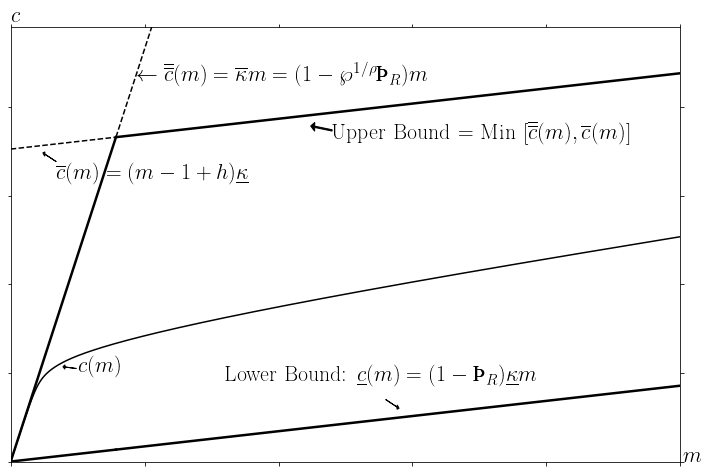

In [14]:
# Plot the consumption function and its bounds

cMaxLabel = r'$\overline{c}(m)= (m-1+h)\tilde{\kappa}$'
cMinLabel = r'Lower Bound: $\tilde{c}(m)= (1-\pmb{\text{\TH}}_{R})\tilde{\kappa}m$'
if not latexExists:
    cMaxLabel = r'$\bar{c}(m) = (m-1+h)\kappa$'  # Use unicode kludge
    cMinLabel = r'Lower Bound: c̲$(m)= (1-$'+Thorn+r'$_{R})m = \kappa m$'

mPlotMin = 0.0
mPlotMax = 25
# mKnk is point where the two upper bounds meet
mKnk = ((h_inf-1) * mpc_Min)/((1 - UnempPrb**(1.0/CRRA)*(Rfree*DiscFac)**(1.0/CRRA)/Rfree)-mpc_Min)
mBelwKnkPts = 300
mAbveKnkPts = 700
mBelwKnk = np.linspace(mPlotMin, mKnk, mBelwKnkPts)
mAbveKnk = np.linspace(mKnk, mPlotMax, mAbveKnkPts)
mFullPts = np.linspace(mPlotMin, mPlotMax, mBelwKnkPts+mAbveKnkPts)

plt.figure(figsize=(12, 8))
cTopMult = 1.12
plt.plot(mFullPts, soln.cFunc(mFullPts), color="black")
plt.plot(mBelwKnk, cFunc_Uncnst(mBelwKnk), color="black", linestyle="--")
plt.plot(mAbveKnk, cFunc_Uncnst(mAbveKnk), color="black", linewidth=2.5)
plt.plot(mBelwKnk, cFunc_TopBnd(mBelwKnk), color="black", linewidth=2.5)
plt.plot(mAbveKnk, cFunc_TopBnd(mAbveKnk), color="black", linestyle="--")
plt.plot(mBelwKnk, cFunc_BotBnd(mBelwKnk), color="black", linewidth=2.5)
plt.plot(mAbveKnk, cFunc_BotBnd(mAbveKnk), color="black", linewidth=2.5)
plt.tick_params(labelbottom=False, labelleft=False, left='off',
                right='off', bottom='off', top='off')
plt.xlim(mPlotMin, mPlotMax)
plt.ylim(mPlotMin, cTopMult*cFunc_Uncnst(mPlotMax))
plt.text(mPlotMin, cTopMult*cFunc_Uncnst(mPlotMax)+0.05, "$c$", fontsize=22)
plt.text(mPlotMax+0.1, mPlotMin, "$m$", fontsize=22)
plt.text(2.5, 1, r'$c(m)$', fontsize=22, fontweight='bold')
upper_upper_bound_m = 4.6
if latexExists:
    plt.text(upper_upper_bound_m+0.1, cFunc_TopBnd(upper_upper_bound_m), r'$~\leftarrow \overline{\overline{c}}(m)= \overline{\MPC}m = (1-\UnempPrb^{1/\CRRA}\pmb{\text{\TH}}_{R})m$',
             fontsize=22, fontweight='bold')
else:
    plt.text(6, 5, r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}$'+Thorn+'$_{R})m$',
             fontsize=22, fontweight='bold')
upper_bound_m = 12
plt.text(
    upper_bound_m, cFunc_Uncnst(upper_bound_m)-0.3, r'Upper Bound $ = $ Min $[\overline{\overline{c}}(m),\overline{c}(m)]$', fontsize=22, fontweight='bold')
plt.text(8, 0.9, cMinLabel, fontsize=22, fontweight='bold')
lower_unc_bound_m = 1.7
lower_unc_bound_c = cFunc_Uncnst(lower_unc_bound_m)-0.2
plt.text(lower_unc_bound_m, lower_unc_bound_c-0.2, cMaxLabel, fontsize=22, fontweight='bold')
plt.arrow(2.45, 1.05, -0.5, 0.02, head_width=0.05, width=0.001,
          facecolor='black', length_includes_head='True')
plt.arrow(lower_unc_bound_m, lower_unc_bound_c, -0.5, 0.1, head_width=0.05, width=0.001,
          facecolor='black', length_includes_head='True')
plt.arrow(upper_bound_m, cFunc_Uncnst(upper_bound_m)-0.2, -0.8, 0.05, head_width=0.1, width=0.015,
          facecolor='black', length_includes_head='True')
unconst_m = 4.5
plt.arrow(5.95, 5.05, -0.4, mPlotMin, head_width=0.05, width=0.001,
          facecolor='black', length_includes_head='True')
plt.arrow(14, 0.70, 0.5, -0.1, head_width=0.05, width=0.001,
          facecolor='black', length_includes_head='True')

makeFig('cFuncBounds')

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ-ark.github.io/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining $\tilde{κ}$
as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = \tilde{\kappa}$.

The paper also derives an analytical limit $\bar{\MPC}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\MPC}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

`# Make and plot figure showing the upper and lower limites of the MPC:`


Saving figure MPCLimits in ../../Figures


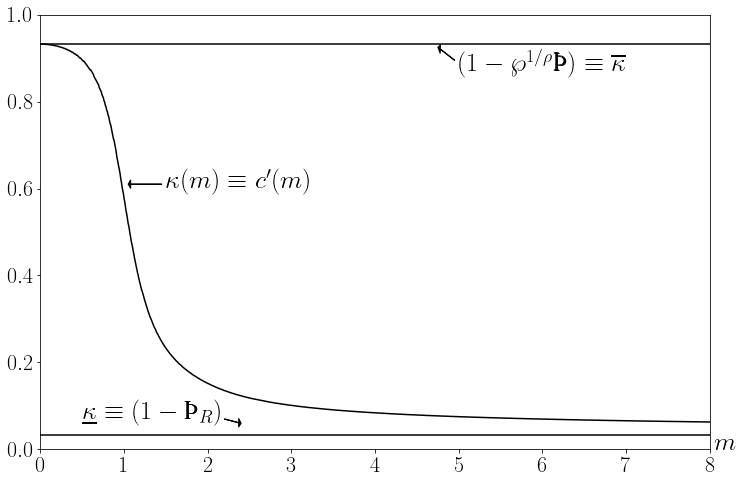

In [15]:
# The last figure shows the upper and lower limits of the MPC

mPlotMax = 8

plt.figure(figsize=(12, 8))
# Set the plot range of m
m = np.linspace(0.001, mPlotMax, mPts)

# Use the HARK method derivative to get the derivative of cFunc, and which constitutes the MPC
MPC = soln.cFunc.derivative(m)

# Define the upper bound of MPC
#mpc_Max = (1 - UnempPrb ** (1.0/CRRA)*(R*DiscFac)**(1.0/CRRA)/R)

# Define the lower bound of MPC
#MPCLower = mpc_Min

kappaDef = r'$\tilde{\kappa}\equiv(1-\pmb{\text{\TH}}_{R})$'
if not latexExists:
    kappaDef = r'κ̲$\equiv(1-$'+Thorn+'$_{R})$'

plt.plot(m, MPC, color='black')
plt.plot([mPlotMin, mPlotMax], [mpc_Max, mpc_Max], color='black')
plt.plot([mPlotMin, mPlotMax], [mpc_Min, mpc_Min], color='black')
plt.xlim(mPlotMin, mPlotMax)
plt.ylim(0, 1)  # MPC bounds are between 0 and 1

if latexExists:
    plt.text(1.5, 0.6, r'$\MPC(m) \equiv c^{\prime}(m)$', fontsize=26, fontweight='bold')
    plt.text(5, 0.87, r'$(1-\UnempPrb^{1/\CRRA}\pmb{\text{\TH}})\equiv \overline{\MPC}$',
             fontsize=26, fontweight='bold')  # Use Thorn character
else:
    plt.text(1.5, 0.6, r'$\kappa(m) \equiv c^{\prime}(m)$', fontsize=26, fontweight='bold')
    plt.text(5, 0.87, r'$(1-\wp^{1/\rho}$'+Thorn+'${R})\equiv \bar{\kappa}$',
             fontsize=26, fontweight='bold')  # Use Phi instead of Thorn (alas)

plt.text(0.5, 0.07, kappaDef, fontsize=26, fontweight='bold')
plt.text(mPlotMax+0.05, mPlotMin, "$m$", fontsize=26)
plt.arrow(1.45, 0.61, -0.4, mPlotMin, head_width=0.02, width=0.001,
          facecolor='black', length_includes_head='True')
plt.arrow(2.2, 0.07, 0.2, -0.01, head_width=0.02, width=0.001,
          facecolor='black', length_includes_head='True')
plt.arrow(4.95, 0.895, -0.2, 0.03, head_width=0.02, width=0.001,
          facecolor='black', length_includes_head='True')

makeFig('MPCLimits')

# Summary

[Two tables in the paper](https://econ-ark.github.io/BufferStockTheory/#Factors-Defined-And-Compared) summarize the various definitions, and then articulate conditions required for the problem to have a nondegenerate solution.  Among the nondegenerate cases, the most interesting result is that if the Growth Impatience Condition holds there will be a target level of wealth.

### Appendix: Options for Interacting With This Notebook <a id='optionsForInstalling'></a>

1. [View (static version)](https://github.com/llorracc/BufferStockTheory/blob/master/Code/Python/BufferStockTheory.ipynb) on GitHub (warning:  GitHub does not render Jupyter notebooks reliably)
1. [Launch Online Interactive Version](https://econ-ark.org/materials/BufferStockTheory/#launch)
1. For fast (local) execution, install [econ-ark](http://github.com/econ-ark) on your computer ([QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md)) then follow these instructions to retrieve the full contents of the `BufferStockTheory` [REMARK](https://github.com/econ-ark/REMARK):
   1. At a command line, change the working directory to the one where you want to install
       * On unix, if you install in the `/tmp` directory, the installation will disappear after a reboot:
       * `cd /tmp`
   1. `git clone https://github.com/econ-ark/REMARK --recursive`
   1. `cd REMARK/REMARKs/BufferStockTheory`
   1. `jupyter notebook BufferStockTheory.ipynb`

### Appendix: Perfect foresight agent failing both the FHWC and RIC

.............................................................................................................................................................................................................................................................................................................................................................................


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 1.0
	LivPrb: 1.0
	CRRA: 2
	Rfree: 0.98
	PermGroFac: 0.99
	BoroCnstArt: 0.0
	MaxKinks: 400
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * permShk)
	bNrm = kNrm * RNrm
	yNrm = tranShk
	mNrm = bNrm + yNrm


...................................
Saving figure PFGICRawHoldsFHWCFailsRICFails in ../../Figures


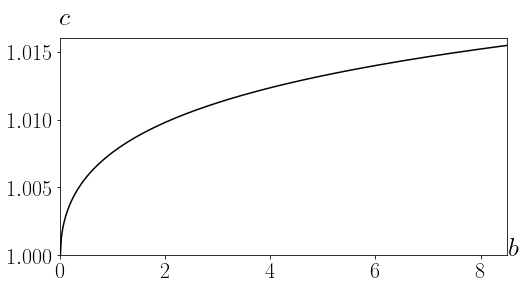

In [16]:
PFGICRawHoldsFHWCFailsRICFails_par = deepcopy(init_perfect_foresight)

# Replace parameters.
PFGICRawHoldsFHWCFailsRICFails_par['Rfree'] = 0.98
PFGICRawHoldsFHWCFailsRICFails_par['DiscFac'] = 1.0
PFGICRawHoldsFHWCFailsRICFails_par['PermGroFac'] = [0.99]
PFGICRawHoldsFHWCFailsRICFails_par['CRRA'] = 2
PFGICRawHoldsFHWCFailsRICFails_par['BoroCnstArt'] = 0.0
PFGICRawHoldsFHWCFailsRICFails_par['T_cycle'] = 1  # No seasonal cycles
PFGICRawHoldsFHWCFailsRICFails_par['T_retire'] = 0
PFGICRawHoldsFHWCFailsRICFails_par['cycles'] = 400  # This many periods
PFGICRawHoldsFHWCFailsRICFails_par['MaxKinks'] = 400
PFGICRawHoldsFHWCFailsRICFails_par['quiet'] = False
PFGICRawHoldsFHWCFailsRICFails_par['BoroCnstArt'] = 0.0  # Borrowing constraint
PFGICRawHoldsFHWCFailsRICFails_par['LivPrb'] = [1.0]

# Create the agent
HWRichButReturnPatientPFConstrainedAgent = \
    PerfForesightConsumerType(**PFGICRawHoldsFHWCFailsRICFails_par,
                              quietly=True
                              )
# Solve and report on conditions
this_agent = HWRichButReturnPatientPFConstrainedAgent
this_agent.solve(quietly=False, messaging_level=logging.DEBUG)

# Plot
mPlotMin, mPlotMax = 1, 9.5
plt.figure(figsize=(8, 4))
m_grid = np.linspace(mPlotMin, mPlotMax, 500)
plt.plot(m_grid-1, this_agent.solution[0].cFunc(m_grid), color="black")
plt.text(mPlotMax-1+0.05, 1, r"$b$", fontsize=26)
plt.text(mPlotMin-1, 1.017, r"$c$", fontsize=26)
plt.xlim(mPlotMin-1, mPlotMax-1)
plt.ylim(mPlotMin, 1.016)

makeFig('PFGICRawHoldsFHWCFailsRICFails')